In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from datetime import datetime

nsm = pd.read_csv('/Users/chanukaalgama/Desktop/SL_electricity_consumption/data/consumption_data/non_smart_meter/monthly_consumption.csv')
wave_1_houseinfo = pd.read_csv('/Users/chanukaalgama/Desktop/SL_electricity_consumption/data/survey_data/wave_1/w1_household_information_and_history.csv')

### 1. Exploring consumption changes over time to understand any shifts in patterns of usage after the tariff hike in feb 2023

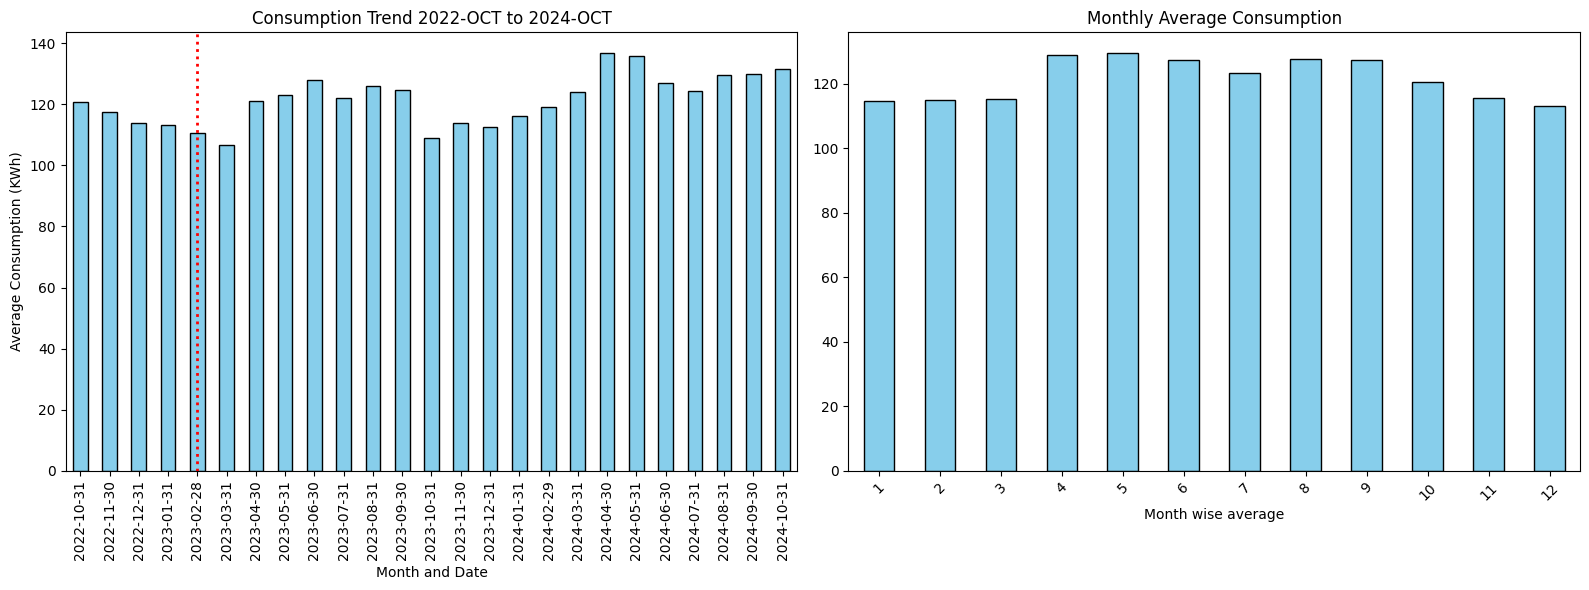

In [7]:
nsm = nsm.ffill()
nsm['consumption'] = pd.to_numeric(nsm['consumption'], errors='coerce')
nsm['month'] = pd.to_datetime(nsm['month'])
nsm['month_only'] = nsm['month'].dt.month
#vertical line issue - recheck
nsm['month'] = nsm['month'].dt.date

grouped = nsm.groupby('month')['consumption'].mean()
grouped_month = nsm.groupby('month_only')['consumption'].mean()

fig, ax = plt.subplots(1, 2, figsize=(16, 6))

grouped.plot(ax=ax[0], kind='bar', color='skyblue', edgecolor='black')
ax[0].set_title("Consumption Trend 2022-OCT to 2024-OCT")
ax[0].set_xlabel('Month and Date')
ax[0].set_ylabel('Average Consumption (KWh)')
highlight_date = pd.to_datetime('2023-02-28').date()
if highlight_date in grouped.index:
    ax[0].axvline(x=grouped.index.get_loc(highlight_date), color='red', linestyle='dotted', linewidth=2)

grouped_month.plot(ax=ax[1], kind='bar', color='skyblue', edgecolor='black')
ax[1].set_title("Monthly Average Consumption")
ax[1].set_xlabel('Month wise average')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### 1.1 Since there is no visible pattern to see from the graphs above, We are looking into the different socio economic classes to see if there are any patterns among classes

The socio economic classes are classified considering the education level and the profession of the household head

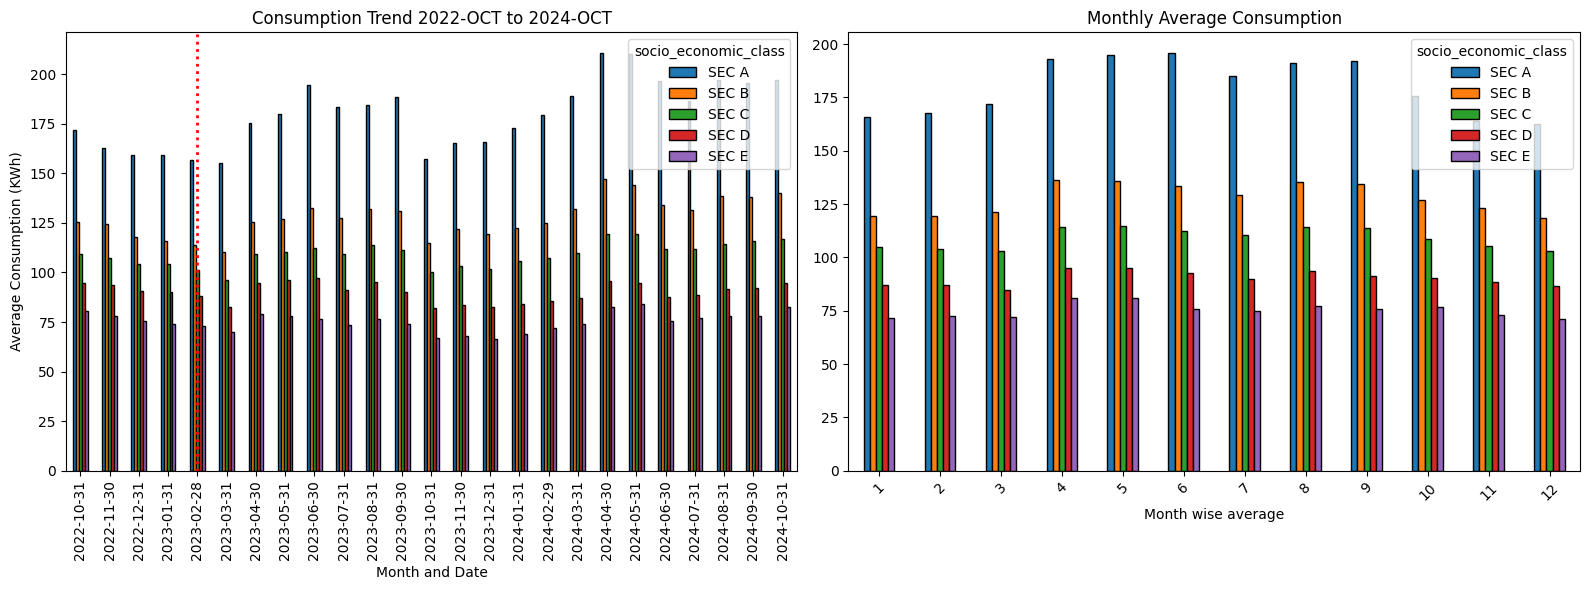

In [8]:
nsm_changed = nsm.merge(
    wave_1_houseinfo[['household_ID', 'socio_economic_class']], 
    on='household_ID', 
    how='inner'
)

grouped = nsm_changed.groupby(['month', 'socio_economic_class'])['consumption'].mean().unstack()
grouped_month = nsm_changed.groupby(['month_only', 'socio_economic_class'])['consumption'].mean().unstack()

fig, ax = plt.subplots(1, 2, figsize=(16, 6))

grouped.plot(ax=ax[0], kind='bar', edgecolor='black')
ax[0].set_title("Consumption Trend 2022-OCT to 2024-OCT")
ax[0].set_xlabel('Month and Date')
ax[0].set_ylabel('Average Consumption (KWh)')

highlight_date = pd.to_datetime('2023-02-28').date()
if highlight_date in grouped.index:
    ax[0].axvline(x=grouped.index.get_loc(highlight_date), color='red', linestyle='dotted', linewidth=2)

grouped_month.plot(ax=ax[1], kind='bar', edgecolor='black')
ax[1].set_title("Monthly Average Consumption")
ax[1].set_xlabel('Month wise average')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### 1.2 Since the number of people living in the household considered as a direct influence to the electricity consumption, we explored any differences among households by categorizing the households into: extended family, large family, small family and single member households as below

In [10]:
def categorize_family_size(members):
    if members >= 10:
        return 'extended family'
    elif 5 <= members < 10:
        return 'large family'
    elif 2 <= members < 5:
        return 'small family'
    else:
        return 'single household'

nsm_changed = nsm.merge(
    wave_1_houseinfo[['household_ID', 'members']], 
    on='household_ID', 
    how='inner'
)

from datetime import datetime

fig, ax = plt.subplots(1, 2, figsize=(16, 6))

grouped = nsm_changed.groupby(['month', 'members'])['consumption'].mean().unstack()
grouped_month = nsm_changed.groupby(['month_only', 'members'])['consumption'].mean().unstack()

grouped.plot(ax=ax[0], kind='line', marker='o')
ax[0].set_title('Average Consumption Trend by Family Type')
ax[0].tick_params(axis='x', rotation=45)
ax[0].set_xlabel('Month and Date')
ax[0].set_ylabel('Average Consumption (KWh)')

grouped_month.plot(ax=ax[1], kind='line', marker='o')
ax[1].set_title('Monthly Average Consumption by Family Type')
ax[1].tick_params(axis='x', rotation=45)
ax[1].set_xlabel('Month wise average')

wave_1_ranges = [(datetime(2023, 11, 15).date(), datetime(2024, 1, 29).date()),
                 (datetime(2024, 6, 1).date(), datetime(2024, 9, 30).date())]

wave_2_range = (datetime(2024, 7, 1).date(), datetime(2024, 12, 31).date())
wave_3_range = (datetime(2024, 10, 1).date(), datetime(2025, 2, 28).date())

# Wave 1: blue
for start, end in wave_1_ranges:
    ax[0].axvspan(start, end, color='peachpuff', alpha=0.3, label='Wave 1')

# Wave 2en
ax[0].axvspan(wave_2_range[0], wave_2_range[1], color='lightgreen', alpha=0.3, label='Wave 2')

ax[0].axvspan(wave_3_range[0], wave_3_range[1], color='lightblue', alpha=0.4, label='Wave 3')

handles, labels = ax[0].get_legend_handles_labels()
unique = dict(zip(labels, handles))
ax[0].legend(unique.values(), unique.keys())

plt.tight_layout()
plt.show()



KeyError: "['members'] not in index"

<Figure size 2000x800 with 0 Axes>

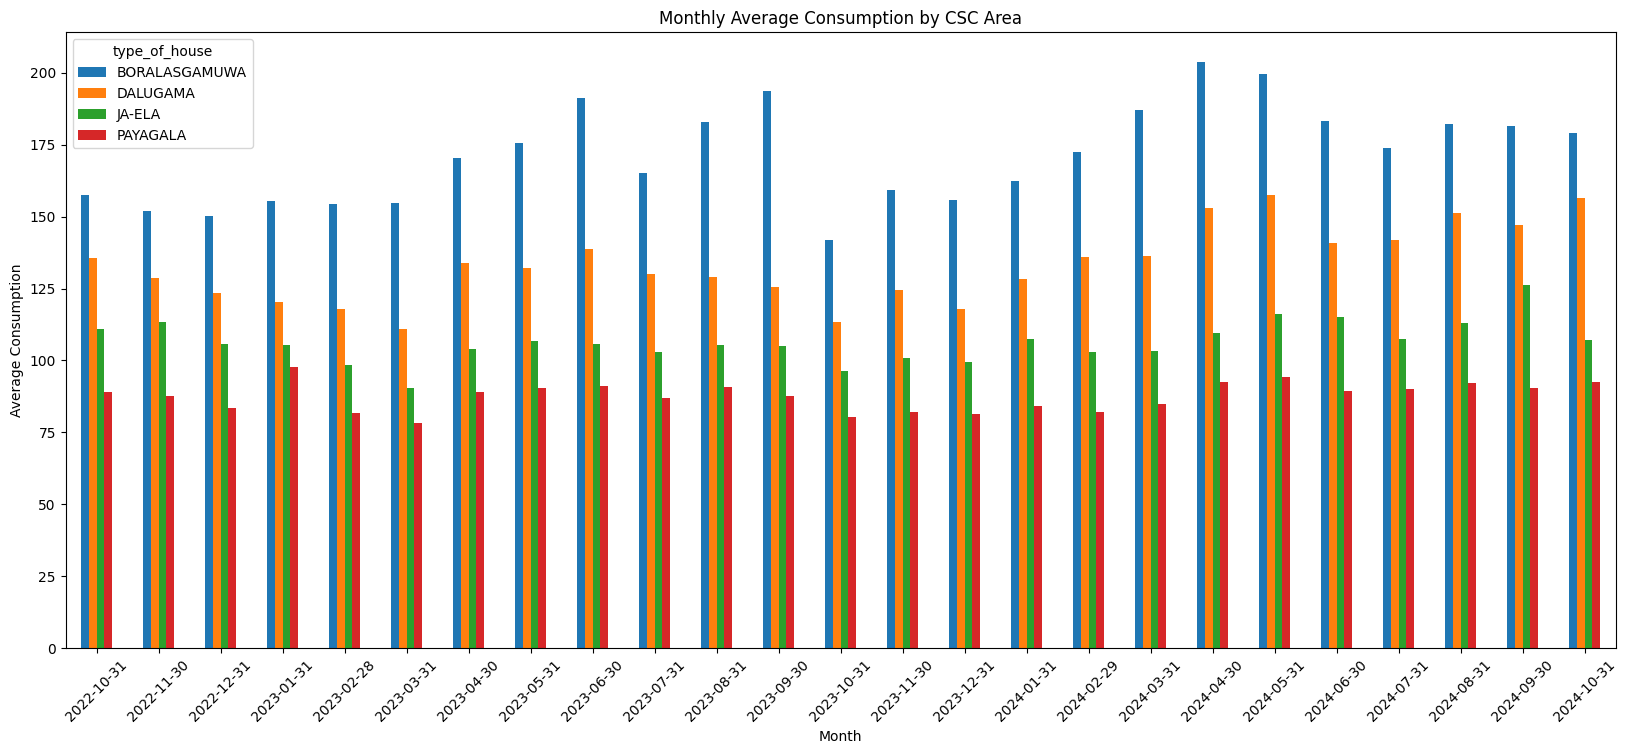

In [46]:
filtered_wave_1_houseinfo = wave_1_houseinfo[wave_1_houseinfo['electricity_provider_csc_area'].isin(['BORALASGAMUWA', 'DALUGAMA', 'JA-ELA', 'PAYAGALA'])]


nsm_changed = nsm.merge(
    filtered_wave_1_houseinfo[['household_ID', 'electricity_provider_csc_area']], 
    on='household_ID', 
    how='inner'
)

grouped = nsm_changed.groupby(['month', 'electricity_provider_csc_area'])['consumption'].mean().unstack()

plt.figure(figsize=(20, 8))
grouped.plot(kind='bar', figsize=(20, 8))

plt.xlabel('Month')
plt.ylabel('Average Consumption')
plt.title('Monthly Average Consumption by CSC Area')
plt.legend(title='type_of_house')
plt.xticks(rotation=45)

plt.show()


building a regressor using the above features to predict consumption

In [11]:
wave_1_houseinfo.electricity_provider_csc_area.value_counts()

electricity_provider_csc_area
MORATUWA NORTH    533
MORATUWA SOUTH    370
PANADURA          357
GALLE             216
KESELWATTA        206
MAHARAGAMA        202
PAYAGALA          196
KALUTARA          189
HIKKADUWA         163
ALUTHGAMA         158
NEGOMBO           152
MAHARA            139
BORALASGAMUWA     131
PITA-KOTTE        124
DALUGAMA          120
AMBALANGODA       118
KOLONNAWA         115
KOTIKAWATTA       108
JA-ELA            106
KANDANA           105
NUGEGODA           93
SEEDUWA            84
WATTALA            78
Name: count, dtype: int64